In [1]:
import pandas as pd
import numpy as np
from scipy.stats import loguniform

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV, cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy import create_engine

import os
import json
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

In [3]:
# подключаемся к базе для чтения информации о пользователях 
DB_FOLDER = 'sqlite:///../data/db/'
DB_NAME = 'twitter_users.db'
DB_PATH = DB_FOLDER + DB_NAME
TABLE_NAME = 'users'

engine = create_engine(DB_PATH)

In [4]:
query = 'SELECT * from {}'.format(TABLE_NAME)
df_users = pd.read_sql(query, engine)

In [5]:
df_users.head(2)

,name,username,description,verified,url,profile_image_url,created_at,id,protected,location,pinned_tweet_id,followers_count,following_count,tweet_count,listed_count,bot
0,Matt Lieber Is Bot,mattlieberisbot,"Retired, for good this time • Inspired by the ...",0,https://t.co/oQKxig8kMF,https://pbs.twimg.com/profile_images/671119389...,2015-11-20T18:53:22.000Z,4303727112,0,None,None,876,0,1182,16,1
1,single cell papers,sc_papers,,0,,https://abs.twimg.com/sticky/default_profile_i...,2015-02-25T20:11:25.000Z,3063139353,0,None,None,325,0,4031,12,1


In [6]:
df_users.isnull().sum()

name                    0
username                0
description             0
verified                0
url                     0
profile_image_url       0
created_at              0
id                      0
protected               0
location              694
pinned_tweet_id      1497
followers_count         0
following_count         0
tweet_count             0
listed_count            0
bot                     0
dtype: int64

In [7]:
df_users['bot'].value_counts()

0    1288
1     731
Name: bot, dtype: int64

In [8]:
df_users['created_at'] = pd.to_datetime(df_users['created_at']).dt.tz_localize(None)

In [9]:
df_users['created_at'].describe()

count                    2019
unique                   2019
top       2009-01-23 08:01:11
freq                        1
first     2006-07-31 18:30:53
last      2016-02-17 21:01:18
Name: created_at, dtype: object

In [10]:
df_users['bot_desc'] = df_users['bot'].apply(lambda x: 'human' if x == 0 else 'bot')

#### Создаем новые дополнительные описательные характеристики

In [11]:
# длина поля description
df_users['desc_len'] = df_users['description'].apply(lambda x: len(x))

# "возраст" аккаунта (в днях)
df_users['profile_age'] = (pd.Timestamp('now') - df_users['created_at']).dt.days

# наличие указанной локации в профиле
df_users['has_location'] = df_users['location'].apply(lambda x: 0 if pd.isnull(x) else 1)

# наличие url в профиле
df_users['has_url'] = df_users['url'].apply(lambda x: 1 if len(x) > 0 else 0)

In [12]:
df_users.head(3)

,name,username,description,verified,url,profile_image_url,created_at,id,protected,location,pinned_tweet_id,followers_count,following_count,tweet_count,listed_count,bot,bot_desc,desc_len,profile_age,has_location,has_url
0,Matt Lieber Is Bot,mattlieberisbot,"Retired, for good this time • Inspired by the ...",0,https://t.co/oQKxig8kMF,https://pbs.twimg.com/profile_images/671119389...,2015-11-20 18:53:22,4303727112,0,None,None,876,0,1182,16,1,bot,95,2030,0,1
1,single cell papers,sc_papers,,0,,https://abs.twimg.com/sticky/default_profile_i...,2015-02-25 20:11:25,3063139353,0,None,None,325,0,4031,12,1,bot,0,2298,0,0
2,lucarivera16,lucarivera16,Inspiring cooks everywhere since 1956.,0,,https://pbs.twimg.com/profile_images/718131475...,2015-01-01 17:44:39,2955142070,0,"Dublin, United States",None,6,0,202,1,1,bot,38,2353,1,0


In [13]:
# выбираем переменные из данных о пользователях, которые будем использовать при обучении моделей

important_cols = [
    'followers_count',
    'following_count', 
    'tweet_count', 
    'listed_count', 
    'desc_len',
    'profile_age',
    'protected', 
    'verified',
    'has_location',
    'has_url'
]

target = ['bot']

#### Визуализируем выбранные переменные, чтобы убедиться, что они значимы для моделирования целевой переменной

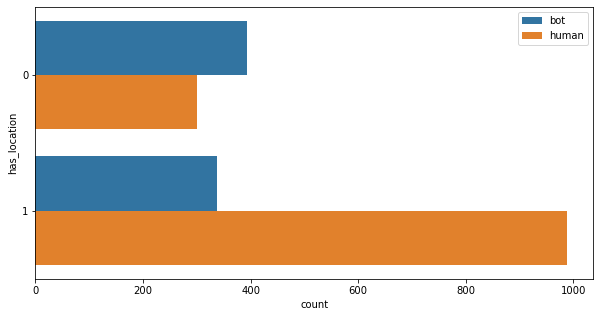

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
sns.countplot(data=df_users, y='has_location', hue='bot_desc', ax=ax)
plt.legend(title='')
plt.show()

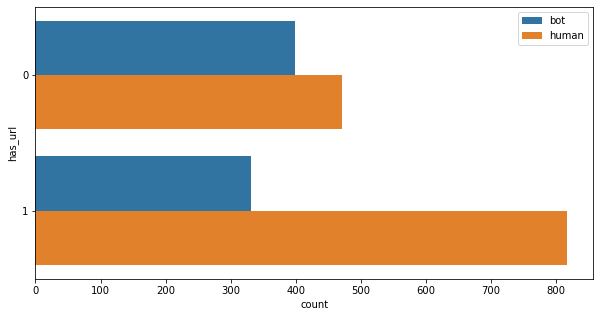

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
sns.countplot(data=df_users, y='has_url', hue='bot_desc', ax=ax)
plt.legend(title='')
plt.show()

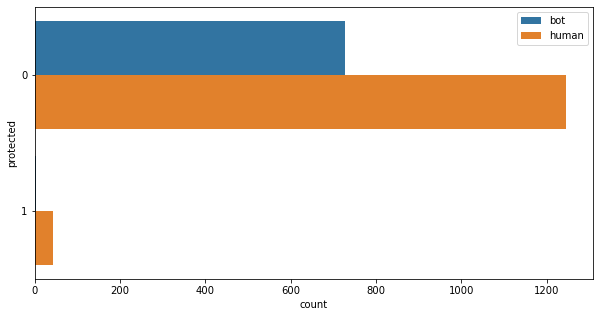

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
sns.countplot(data=df_users, y='protected', hue='bot_desc', ax=ax)
plt.legend(title='')
plt.show()

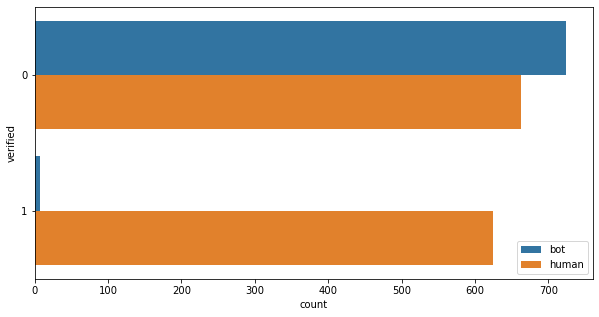

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
sns.countplot(data=df_users, y='verified', hue='bot_desc', ax=ax)
plt.legend(title='')
plt.show()

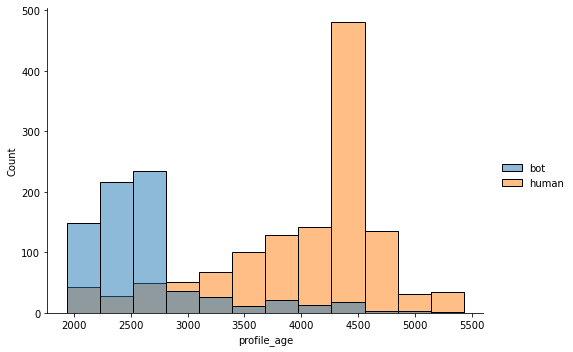

In [18]:
fig = sns.displot(data=df_users, x='profile_age', hue='bot_desc', height=5, aspect=1.4)
fig._legend.set_title('')
plt.show()

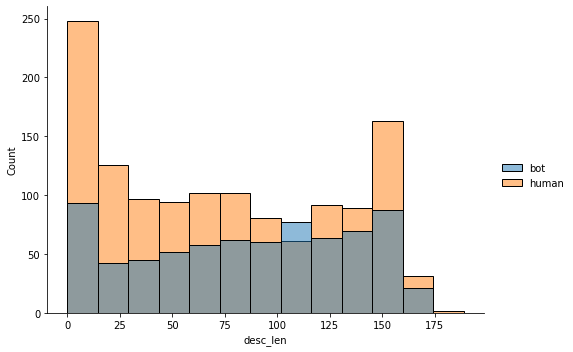

In [19]:
fig = sns.displot(data=df_users, x='desc_len', hue='bot_desc', height=5, aspect=1.4)
fig._legend.set_title('')
plt.show()

In [20]:
df_users['listed_count'].describe()

count      2019.000000
mean       4027.214958
std       18436.910903
min           0.000000
25%           5.000000
50%          40.000000
75%        1170.500000
max      543082.000000
Name: listed_count, dtype: float64

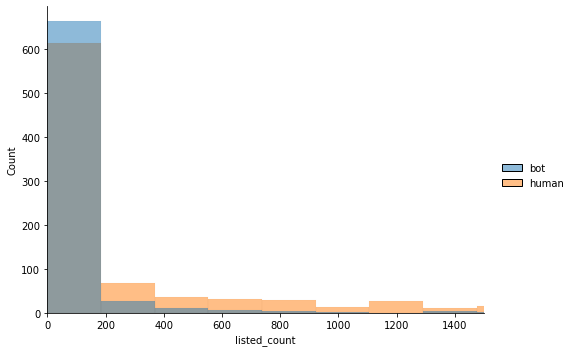

In [21]:
fig = sns.displot(data=df_users, x='listed_count', hue='bot_desc', height=5, aspect=1.4)
fig._legend.set_title('')
plt.xlim(0, 1500)
plt.show()

In [22]:
df_users['followers_count'].describe()

count    2.019000e+03
mean     1.803953e+06
std      8.795507e+06
min      0.000000e+00
25%      1.410000e+02
50%      1.252000e+03
75%      9.725450e+04
max      1.295859e+08
Name: followers_count, dtype: float64

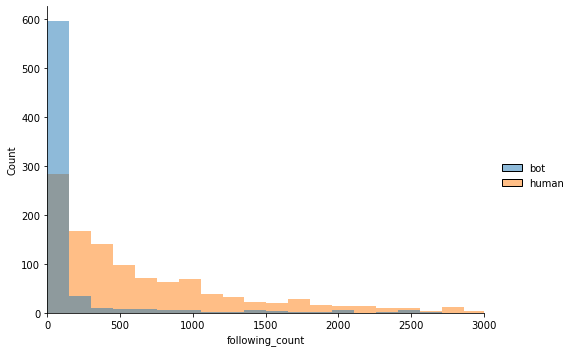

In [23]:
fig = sns.displot(data=df_users, x='following_count', hue='bot_desc', height=5, aspect=1.4)
fig._legend.set_title('')
plt.xlim(0, 3000)
plt.show()

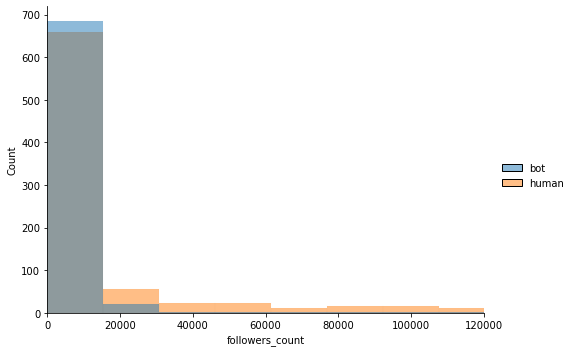

In [24]:
fig = sns.displot(data=df_users, x='followers_count', hue='bot_desc', height=5, aspect=1.4)
fig._legend.set_title('')
plt.xlim(0, 120000)
plt.show()

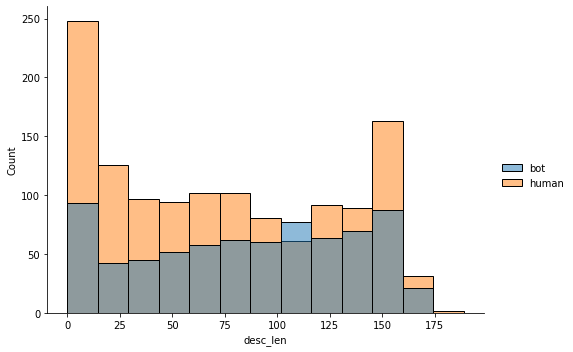

In [25]:
fig = sns.displot(data=df_users, x='desc_len', hue='bot_desc', height=5, aspect=1.4)
fig._legend.set_title('')
# plt.xlim(0, 120000)
plt.show()

In [26]:
# задаем независимые переменные Х и зависимую (целевую) переменную у

X, y = df_users[important_cols], df_users[target]

In [27]:
# подбираем параметры для первой модели (Логистическая регрессия)

model_LR = LogisticRegression(solver='liblinear', penalty='l1', random_state=1)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

space_LR = {
    'C': loguniform(0.01, 10)
}

search_LR = RandomizedSearchCV(
    model_LR,
    space_LR, 
    n_iter=500, 
    scoring='accuracy', 
    n_jobs=-1, 
    cv=cv, 
    refit=False, 
    random_state=1
)

result_LR = search_LR.fit(X, y)

# лучшие параметры модели
result_LR.best_params_, result_LR.best_score_

({'C': 4.156876569947477}, 0.8845918920250234)

In [28]:
# строим модель с наилучшими параметрами, подобранными на предыдущем шаге, и тестируем на кросс-валидационной выборке

model1 = LogisticRegression(solver='liblinear', penalty='l1', C=7.84, random_state=1)
scores1 = cross_val_score(model1, X, y, cv=10)

print('Accuracy for Logistic Regression model on 10-fold CV: {:.4f} +- {:.4f}'.format(scores1.mean(), scores1.std()))

Accuracy for Logistic Regression model on 10-fold CV: 0.8866 +- 0.0248


In [29]:
# подбираем параметры для второй модели (Случайный лес)

model_RF = RandomForestClassifier(bootstrap=True, random_state=1)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

space_RF = {
    'max_depth': [20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 4, 6, 8],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000],
    'min_impurity_decrease': [0, 0.001, 0.01, 0.02, 0.05, 0.1, 0.2]
}

search_RF = RandomizedSearchCV(
    model_RF,
    space_RF, 
    n_iter=500, 
    scoring='accuracy', 
    n_jobs=-1, 
    cv=cv, 
    refit=False, 
    random_state=1
)

result_RF = search_RF.fit(X, y)

# лучшие параметры модели
result_RF.best_params_, result_RF.best_score_

({'n_estimators': 600,
  'min_samples_split': 10,
  'min_samples_leaf': 2,
  'min_impurity_decrease': 0,
  'max_features': 'auto',
  'max_depth': 50},
 0.9194300773360918)

In [30]:
# строим модель с наилучшими параметрами, подобранными на предыдущем шаге, и тестируем на кросс-валидационной выборке

model2 = RandomForestClassifier(
    n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', max_depth=80, random_state=1, bootstrap=True)

scores2 = cross_val_score(model2, X, y, cv=10)

print('Accuracy for Random Forest model on 10-fold CV: {:.4f} +- {:.4f}'.format(scores2.mean(), scores2.std()))

Accuracy for Random Forest model on 10-fold CV: 0.9163 +- 0.0176


In [31]:
# подбираем параметры для третьей модели (К ближайших соседей)

model_KNN = KNeighborsClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

space_KNN = {
    'n_neighbors': [5, 8, 10, 12, 15, 20, 25],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

search_KNN = RandomizedSearchCV(
    model_KNN,
    space_KNN, 
    n_iter=500, 
    scoring='accuracy', 
    n_jobs=-1, 
    cv=cv, 
    refit=False, 
    random_state=1
)

result_KNN = search_KNN.fit(X, y)

# лучшие параметры модели
result_KNN.best_params_, result_RF.best_score_

({'weights': 'distance', 'n_neighbors': 5, 'algorithm': 'auto'},
 0.9194300773360918)

In [32]:
# строим модель с наилучшими параметрами, подобранными на предыдущем шаге, и тестируем на кросс-валидационной выборке

model3 = KNeighborsClassifier(
    weights='distance', n_neighbors=5, algorithm='auto')

scores3 = cross_val_score(model3, X, y, cv=10)

print('Accuracy for K Nearest Neighbors model on 10-fold CV: {:.4f} +- {:.4f}'.format(scores3.mean(), scores3.std()))

Accuracy for K Nearest Neighbors model on 10-fold CV: 0.8836 +- 0.0232


In [33]:
# подбираем параметры для четвертой модели (Дерево решений)

model_DT = DecisionTreeClassifier(random_state=1)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

space_DT = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_leaf': [2, 4, 6, 8],
    'min_samples_split': [2, 5, 10],
}

search_DT = RandomizedSearchCV(
    model_DT,
    space_DT, 
    n_iter=500, 
    scoring='accuracy', 
    n_jobs=-1, 
    cv=cv, 
    refit=False, 
    random_state=1
)

result_DT = search_DT.fit(X, y)

# лучшие параметры модели
result_DT.best_params_, result_DT.best_score_

({'splitter': 'best',
  'min_samples_split': 2,
  'min_samples_leaf': 8,
  'max_depth': 20,
  'criterion': 'entropy'},
 0.8940109682610053)

In [34]:
# строим модель с наилучшими параметрами, подобранными на предыдущем шаге, и тестируем на кросс-валидационной выборке

model4 = DecisionTreeClassifier(
    splitter='best', min_samples_split=2, min_samples_leaf=8, max_depth=20, criterion='entropy', random_state=1)

scores4 = cross_val_score(model4, X, y, cv=10)

print('Accuracy for Decision Tree model on 10-fold CV: {:.4f} +- {:.4f}'.format(scores4.mean(), scores4.std()))

Accuracy for Random Tree model on 10-fold CV: 0.8950 +- 0.0161
